# Fake News Detection: Modeling and Evaluation

This notebook trains multiple classifiers on TF-IDF features extracted from fake and real news articles and evaluates their performance.

It represents the **final step** in a four-part pipeline. The processed dataset is used to evaluate various machine learning models using standard performance metrics and visualization techniques.

# Import Required Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sqlalchemy import create_engine


# Mount Google Drive and Load Data from SQLite Database

In [17]:
# Mount Google Drive for use with Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Path to database
db_path = '/content/drive/MyDrive/IS619_Project/fakenews.db'
engine = create_engine(f'sqlite:///{db_path}')

# Connect and load from SQLite
conn = sqlite3.connect(db_path)
query = "SELECT article_id, title, body, subject, date, fakeNews FROM news_article"
df_all = pd.read_sql_query(query, conn)

# Rename columns for clarity
df_all.rename(columns={'fakeNews': 'label'}, inplace=True)
print(df_all['label'].value_counts())
df_all.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
label
FAKE    93884
REAL    85668
Name: count, dtype: int64


,article_id,title,body,subject,date,label
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,POLITICS,"December 31, 2017",REAL
1,2,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,POLITICS,"December 29, 2017",REAL
2,3,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,POLITICS,"December 31, 2017",REAL
3,4,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,POLITICS,"December 30, 2017",REAL
4,5,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,POLITICS,"December 29, 2017",REAL


In [18]:
# Convert labels to binary values
df_all['label'] = df_all['label'].map({'FAKE': 0, 'REAL': 1})

# Text Preprocessing with Stopwords and Lemmatization

In [19]:
# Import libraries for text preprocessing
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize stopword list and lemmatizer
stop_words = set(stopwords.words('english'))     # Load English stopwords into a set for fast lookup
lemmatizer = WordNetLemmatizer()                 # Initialize the WordNet lemmatizer

# Define preprocessing function for text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove all digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()  # Tokenize by whitespace
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize remaining words
    return ' '.join(tokens)  # Rejoin tokens into a single string

# Apply the preprocessing function to the 'title' column and store in new 'clean_title' column
df_all['clean_title'] = df_all['title'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# TF-IDF Vectorization and Data Splitting

In [20]:
# TF-IDF feature extraction
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_all['clean_title'])
y = df_all['label']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Topic Modeling with NMF

/tmp/ipython-input-23-3159221645.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")


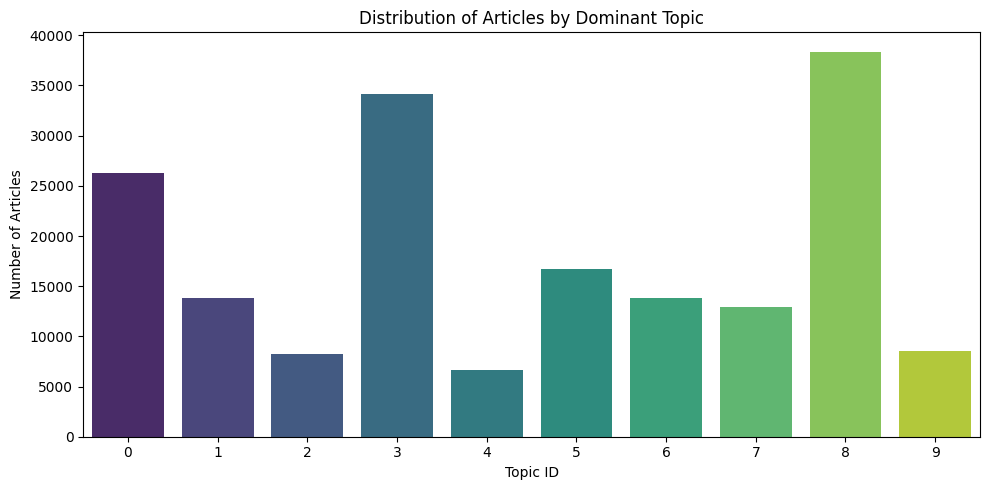


===== Topic 0 - get, watch, administration, supporter, campaign, twitter, president, tweet, donald, trump =====

Title: WATCH: BLACK FEMALE TRUMP EXECUTIVE Reads POWERFUL Letter She Wrote To Dispel LIES Being Told About Trump Family
Text: The video Hillary and the Left will not want America to see Today, I was compelled to sit down and write this letter. Not to anyone in particular, maybe even just for myself. But as a black, female executive at the Trump Organization, I can no longer remain silent about the repeated and reprehensibl...


Title: Trump takes populist message to U.S. heartland in 'thank you' tour
Text: CINCINNATI (Reuters) - President-elect Donald Trump kicked off his post-election “thank you tour” on Thursday by railing against globalization, promising the return of manufacturing jobs to American workers, and vowing to shut U.S. borders to some Middle East migrants. Speaking in an arena that was ...


===== Topic 1 - china, uk, talk, pm, iran, may, eu, brexit, deal, sa

,topic_id,topic_name
0,0,"get, watch, administration, supporter, campaig..."
1,1,"china, uk, talk, pm, iran, may, eu, brexit, de..."
2,2,"rico, chief, official, bill, meet, panel, ryan..."
3,3,"muslim, woman, go, fox, get, cnn, news, black,..."
4,4,"un, missile, japan, korean, nuclear, sanction,..."


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['topic_id'].plot(kind='hist', bins=20, title='topic_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('topic_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='topic_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('topic_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='topic_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['topic_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'topic_id'}, axis=1)
              .sort_values('topic_id', ascending=True))
  xs = counted['topic_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('topic_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('topic_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='topic_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('topic_id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['topic_id'].plot(kind='line', figsize=(8, 4), title='topic_id')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['topic_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='topic_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['topic_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='topic_id', y='topic_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [23]:
# Topic Modeling Using NMF (Optional Enrichment)

from sklearn.decomposition import NMF
import numpy as np

# Reuse the existing TF-IDF matrix (X) generated from df_all['clean_title']
nmf_model = NMF(n_components=10, random_state=42)
nmf_topics = nmf_model.fit_transform(X)

feature_names = tfidf.get_feature_names_out()


# Generate topic labels
topics = []
for topic_idx, topic in enumerate(nmf_model.components_):
    keywords = [feature_names[i] for i in topic.argsort()[-10:]]
    topics.append({
        'topic_id': topic_idx,
        'topic_name': ", ".join(keywords)
    })

topic_dim_df = pd.DataFrame(topics).drop_duplicates(subset=['topic_name'])

# Store topic labels in SQLite
topic_dim_df.to_sql(
    name='topic_dim',
    con=engine,  # SQLAlchemy engine
    index=False,
    if_exists='append',
    method='multi'
)

# Map each article in df_all to its most dominant topic
article_topic_pairs = []
for idx, row in df_all.iterrows():
    topic_vector = nmf_topics[idx]
    dominant_topic = int(np.argmax(topic_vector))
    article_topic_pairs.append({
        'article_id': row['article_id'],
        'topic_id': dominant_topic
    })

article_topic_df = pd.DataFrame(article_topic_pairs)

# Save article-topic mappings
article_topic_df.to_sql(
    name='article_topic',
    con=engine,
    index=False,
    if_exists='append',
    method='multi',
    chunksize=500  # anything ≤ 500 works better with SQLite
)

# Count articles assigned to each topic
topic_counts = article_topic_df['topic_id'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.xlabel("Topic ID")
plt.ylabel("Number of Articles")
plt.title("Distribution of Articles by Dominant Topic")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Merge topic info into main DataFrame for inspection
df_topics = pd.merge(df_all, article_topic_df, on='article_id', how='left')

# Merge topic names as well
df_topics = pd.merge(df_topics, topic_dim_df, on='topic_id', how='left')

# Display 2 sample articles per topic
for topic_id in sorted(df_topics['topic_id'].unique()):
    print(f"\n===== Topic {topic_id} - {df_topics[df_topics['topic_id'] == topic_id]['topic_name'].iloc[0]} =====")
    sample_df = df_topics[df_topics['topic_id'] == topic_id].sample(n=2, random_state=42)
    for idx, row in sample_df.iterrows():
        print(f"\nTitle: {row['title']}\nText: {row['body'][:300]}...\n")

# Optional: View top 5 topics
print("Top 5 generated topics:")
display(topic_dim_df.head())

# Model Training and Evaluation

=== Logistic Regression ===
              precision    recall  f1-score   support

        FAKE       0.97      0.96      0.96     18977
        REAL       0.95      0.97      0.96     16934

    accuracy                           0.96     35911
   macro avg       0.96      0.96      0.96     35911
weighted avg       0.96      0.96      0.96     35911




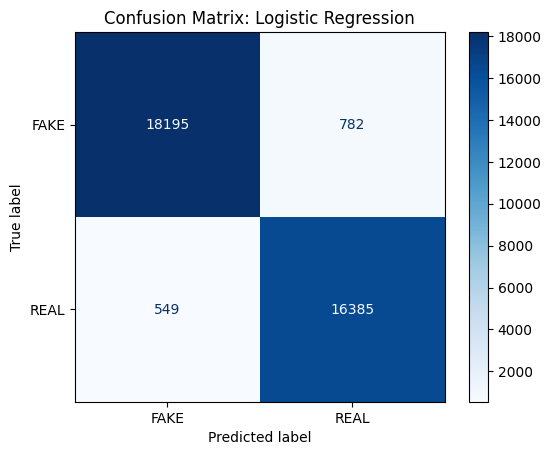

=== Naive Bayes ===
              precision    recall  f1-score   support

        FAKE       0.94      0.95      0.95     18977
        REAL       0.95      0.93      0.94     16934

    accuracy                           0.94     35911
   macro avg       0.94      0.94      0.94     35911
weighted avg       0.94      0.94      0.94     35911




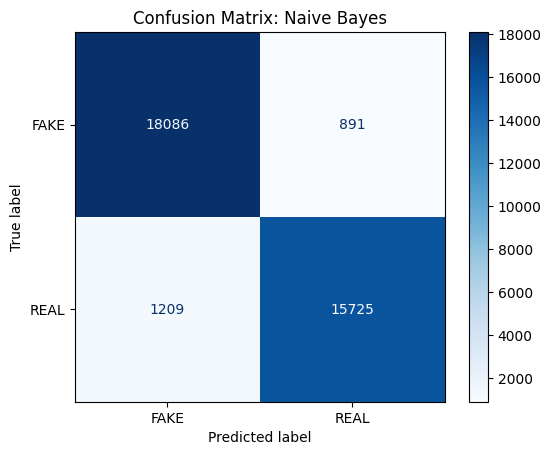

=== Random Forest ===
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00     18977
        REAL       1.00      1.00      1.00     16934

    accuracy                           1.00     35911
   macro avg       1.00      1.00      1.00     35911
weighted avg       1.00      1.00      1.00     35911




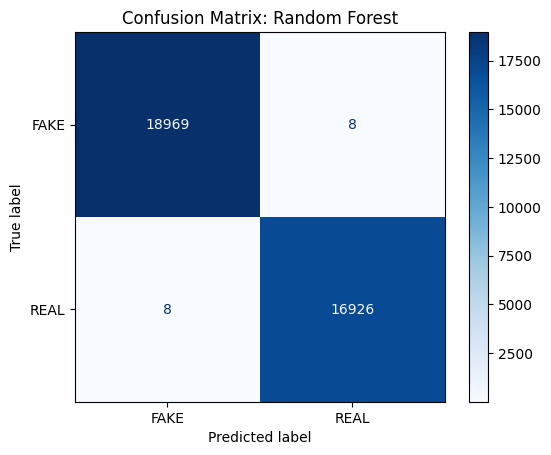

=== SVM ===
              precision    recall  f1-score   support

        FAKE       0.98      0.97      0.98     18977
        REAL       0.97      0.98      0.97     16934

    accuracy                           0.97     35911
   macro avg       0.97      0.98      0.97     35911
weighted avg       0.98      0.97      0.97     35911




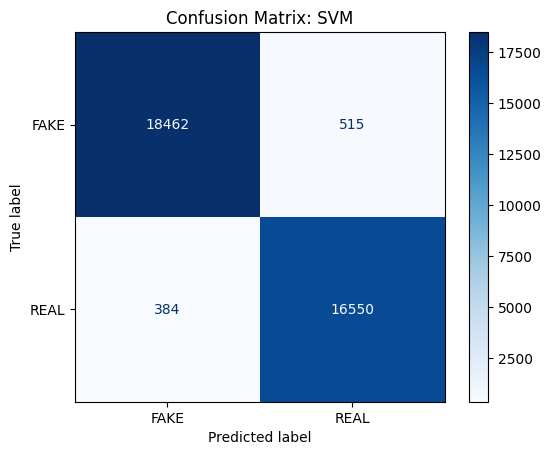

In [24]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": LinearSVC()
}

# Store results
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1})

    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))
    print("")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()


# Summary Results Visualization

/tmp/ipython-input-25-664220661.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='F1 Score', y='Model', palette='magma')


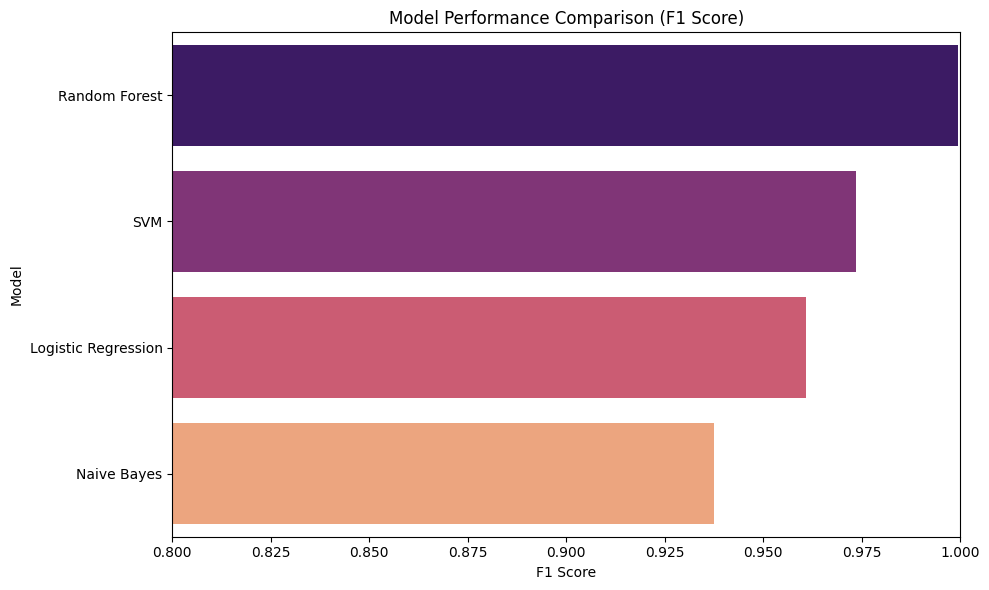

,Model,Accuracy,F1 Score
2,Random Forest,0.999554,0.999528
3,SVM,0.974966,0.973558
0,Logistic Regression,0.962936,0.960969
1,Naive Bayes,0.941522,0.937407


In [25]:
# Display performance summary
results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='F1 Score', y='Model', palette='magma')
plt.title('Model Performance Comparison (F1 Score)')
plt.xlim(0.8, 1.0)
plt.tight_layout()
plt.show()

results_df
